## Base Model Setup 

In [5]:
!git clone https://github.com/sahilabudhwani/ML-Detection-for-Malaria.git

fatal: destination path 'ML-Detection-for-Malaria' already exists and is not an empty directory.


In [6]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning

from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from keras import regularizers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from keras.optimizers import adam_v2
import tensorflow as tf
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random


In [4]:
import fnmatch 
data=[]
labels=[]

Parasitized=fnmatch.filter(os.listdir("/content/ML-Detection-for-Malaria/Malaria_Dataset/Parasitized"), '*png')
for a in Parasitized: 
    img= Image.open(r'/content/ML-Detection-for-Malaria/Malaria_Dataset/Parasitized/' +a)
    img=img.resize((128,128)) 
    data.append(np.asarray(img))
    labels.append(0)
  


Uninfected=fnmatch.filter(os.listdir("/content/ML-Detection-for-Malaria/Malaria_Dataset/Uninfected"), '*png')
for u in Uninfected: 
    img= Image.open(r'/content/ML-Detection-for-Malaria/Malaria_Dataset/Uninfected/' +u)
    img=img.resize((128,128)) 
    data.append(np.asarray(img))
    labels.append(1)
    

In [7]:
Cells=np.array(data)
labels=np.array(labels)
print(Cells.shape, labels.shape)

(27558, 128, 128, 3) (27558,)


In [8]:
Cells=np.stack(data)
labels=np.stack(labels)
print(Cells.shape, labels.shape)

(27558, 128, 128, 3) (27558,)


In [9]:
np.save("Cells",Cells)
np.save("labels",labels)

In [10]:
Cells=np.load("Cells.npy",allow_pickle=True)
labels=np.load("labels.npy",allow_pickle=True)

In [11]:
num_classes = 2

labels = keras.utils.np_utils.to_categorical(labels, num_classes)
print(labels[0])

[1. 0.]


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(Cells, labels, test_size = 0.2, random_state=5)
print('Train dataset number: {}'.format(len(x_train)))
print('Test dataset number: {}'.format(len(x_val)))

Train dataset number: 22046
Test dataset number: 5512


## Transfer Learning Setup

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 


## Loading VGG16 model
vgg16Base = VGG16(weights="imagenet", include_top=False,input_shape= (128,128,3) )
vgg16Base.trainable = False

resnetBase = ResNet50(weights="imagenet", include_top=False,input_shape= (128,128,3) )
resnetBase.trainable = False ## Not trainable weights



In [14]:
resnetBase.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [15]:
vgg16Base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [16]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    resnetBase,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 50)                1638450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 25,227,224
Trainable params: 1,639,512
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
model.compile(tf.optimizers.Adam(learning_rate = 0.01) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping


batch_size = 32
epochs = 25

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model6.h5',
        monitor='accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=10,verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/25
689/689 [==============================] - ETA: 0s - loss: 1.2247 - accuracy: 0.8925
Epoch 1: accuracy improved from -inf to 0.89250, saving model to model6.h5
689/689 [==============================] - 49s 51ms/step - loss: 1.2247 - accuracy: 0.8925 - val_loss: 0.2001 - val_accuracy: 0.9184
Epoch 2/25
689/689 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9267
Epoch 2: accuracy improved from 0.89250 to 0.92674, saving model to model6.h5
689/689 [==============================] - 34s 49ms/step - loss: 0.1897 - accuracy: 0.9267 - val_loss: 0.1889 - val_accuracy: 0.9341
Epoch 3/25
688/689 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9301
Epoch 3: accuracy improved from 0.92674 to 0.93024, saving model to model6.h5
689/689 [==============================] - 35s 50ms/step - loss: 0.1740 - accuracy: 0.9302 - val_loss: 0.1728 - val_accuracy: 0.9302
Epoch 4/25
689/689 [==============================] - ETA: 0s - loss: 0.1618 - acc

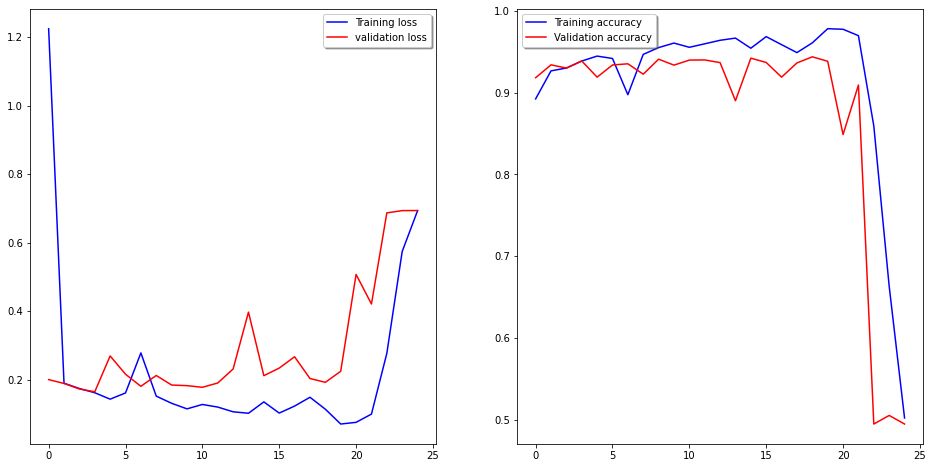

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [21]:
from tensorflow.keras.models import load_model

model = load_model('model6.h5')

In [28]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2244507223367691
Test accuracy: 0.9384978413581848


In [29]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.97      0.91      0.94      2785
   Parasited       0.91      0.97      0.94      2727

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



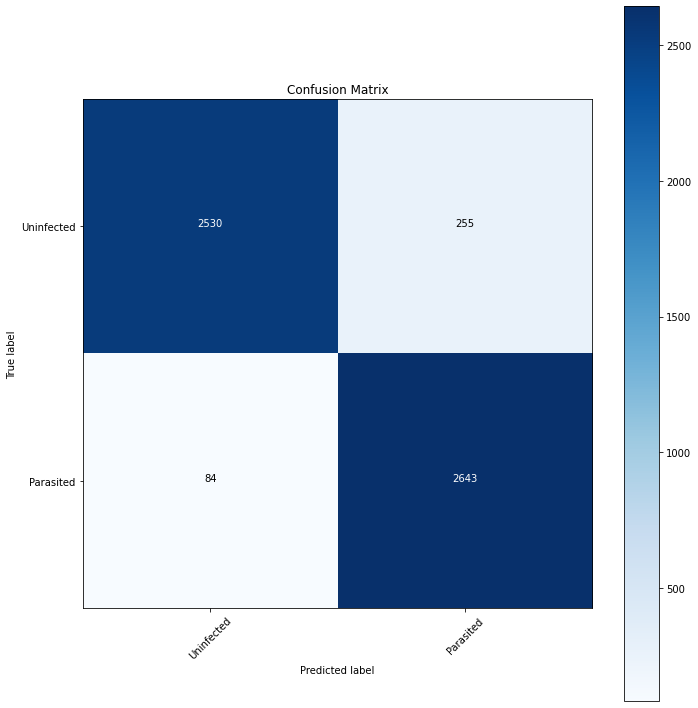

In [31]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = (model.predict(x_val) > 0.5).astype("int32")

y_test_c = np.argmax(y_val, axis=1)
target_names = ["Uninfected", "Parasited"]

Y_pred = np.argmax(model.predict(x_val),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))

In [32]:
from tensorflow.keras import layers, models


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    vgg16Base,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 50)                409650    
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 2)                 42        
                                                                 
Total params: 15,125,400
Trainable params: 410,712
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
model.compile(tf.optimizers.Adam(learning_rate = 0.1) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping


batch_size = 32
epochs = 25

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model7.h5',
        monitor='accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=5,verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/25
689/689 [==============================] - ETA: 0s - loss: 13.4706 - accuracy: 0.5035
Epoch 1: accuracy improved from -inf to 0.50354, saving model to model7.h5
689/689 [==============================] - 49s 68ms/step - loss: 13.4706 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4947
Epoch 2/25
689/689 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.4962
Epoch 2: accuracy did not improve from 0.50354
689/689 [==============================] - 45s 65ms/step - loss: 0.6971 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 3/25
689/689 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.4986
Epoch 3: accuracy did not improve from 0.50354
689/689 [==============================] - 45s 66ms/step - loss: 0.6966 - accuracy: 0.4986 - val_loss: 0.6951 - val_accuracy: 0.4947
Epoch 4/25
689/689 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5025
Epoch 4: accuracy did not improve from 0.50354

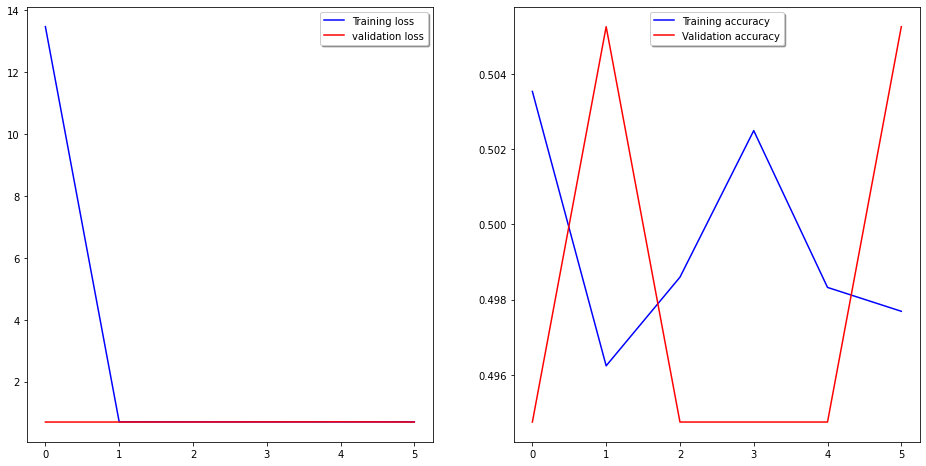

In [36]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [37]:
from tensorflow.keras.models import load_model

model = load_model('model7.h5')

In [38]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6931986212730408
Test accuracy: 0.49473875761032104


In [39]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.00      0.00      0.00      2785
   Parasited       0.49      1.00      0.66      2727

    accuracy                           0.49      5512
   macro avg       0.25      0.50      0.33      5512
weighted avg       0.24      0.49      0.33      5512



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


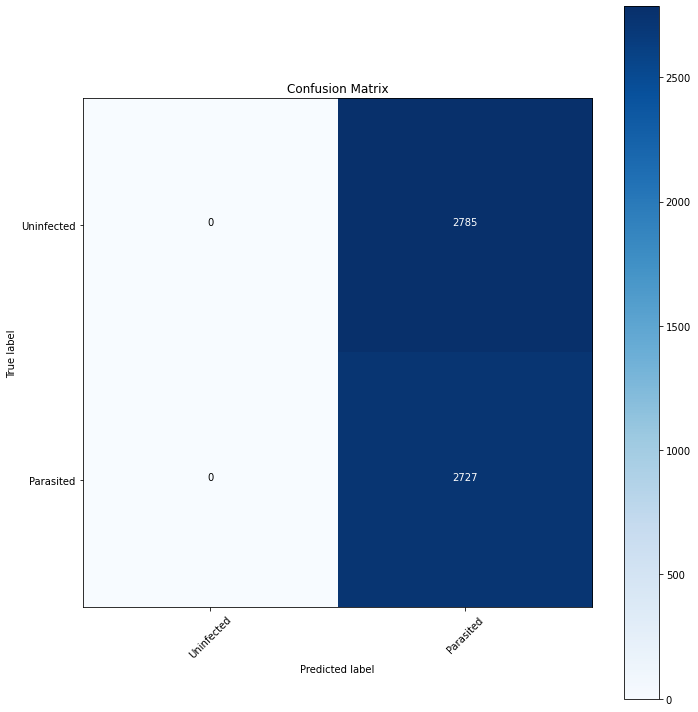

In [41]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = (model.predict(x_val) > 0.5).astype("int32")

y_test_c = np.argmax(y_val, axis=1)
target_names = ["Uninfected", "Parasited"]

Y_pred = np.argmax(model.predict(x_val),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))